# Доверительные интервалы для оценки среднего

In [17]:
from sklearn import model_selection, datasets, linear_model, metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [3]:
blobs = datasets.make_blobs(300, centers=2, cluster_std=6, random_state=1)

In [4]:
X, y = blobs

<Figure size 648x648 with 0 Axes>

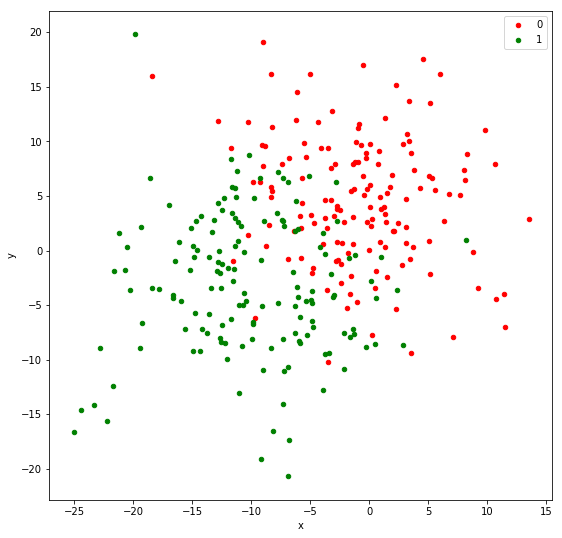

In [5]:
plt.figure(figsize(9, 9))
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1]), index = y)
colors = {0:'red', 1:'green'}
fig, ax = plt.subplots()
grouped = df.groupby(df.index)
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

## Сравнение линейных моделей

### Точечная оценка

In [6]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(blobs[0],
                                                                                   blobs[1],
                                                                                   test_size=15,
                                                                                   random_state=1)

In [7]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

In [8]:
sgd_model = linear_model.SGDClassifier(random_state=0)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

C:\Users\qu4n7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.8888888888888888

### Оценка среднего

In [13]:
ridge_auc_scores = model_selection.cross_val_score(ridge_model, blobs[0], blobs[1], 
                                                  scoring='roc_auc', cv=20)

In [14]:
sgd_auc_scores = model_selection.cross_val_score(sgd_model, blobs[0], blobs[1], 
                                                scoring='roc_auc', cv=20)

C:\Users\qu4n7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\qu4n7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\qu4n7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in 

### Точечная оценка среднего

In [15]:
print('ridge model auc: mean %.3f, std %3f' % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))
print('sgd model auc: mean %.3f, std %.3f' % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))

ridge model auc: mean 0.948, std 0.053658
sgd model auc: mean 0.893, std 0.107


### Интервальная оценка среднего 

In [47]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [48]:
ridge_mean = ridge_auc_scores.mean()
sgd_mean = sgd_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [55]:
print('ridge model mean auc 95%% confidence interval', _zconfint_generic(ridge_mean,
                                                                        sqrt(0.25/len(ridge_auc_scores)),
                                                                        0.05, 'two-sided'))
print('sgd model mean auc 95%% confidence interval', _zconfint_generic(sgd_mean, 
                                                                      sqrt(0.25/len(sgd_auc_scores)),
                                                                     0.05, 'two-sided'))

ridge model mean auc 95%% confidence interval (0.728860436284426, 1.1671217065727166)
sgd model mean auc 95%% confidence interval (0.6736308444476913, 1.111892114735982)


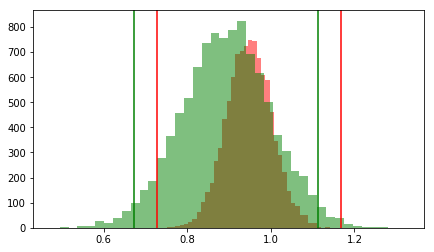

In [66]:
sigma_ridge = ridge_auc_scores.std(ddof=1)
x_ridge = ridge_mean + sigma_ridge * np.random.randn(10000)

sigma_sgd = sgd_auc_scores.std(ddof=1)
x_sgd = sgd_mean + sigma_sgd * np.random.randn(10000)

rcParams["figure.figsize"] = [7, 4]
plt.hist(x_ridge, bins=40, alpha=0.5, color='red');
plt.hist(x_sgd, bins=40, alpha=0.5, color='green');
ridge_line = _zconfint_generic(ridge_mean,sqrt(0.25/len(ridge_auc_scores)),0.05, 'two-sided')
sgd_line = _zconfint_generic(sgd_mean,sqrt(0.25/len(sgd_auc_scores)),0.05, 'two-sided')

for i in ridge_line:
    plt.axvline(x=i, color='red')
    
for i in sgd_line:
    plt.axvline(x=i, color='green')

#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$